# Proyecto 1 - Machine Learning

In [77]:
import pandas as pd
import h5py #archivos h5
from tsfresh import extract_features, select_features #extrae features en series temporales

In [78]:
with h5py.File('train.h5', 'r') as f:
    print("archivo h5", list(f.keys()))   
    #hay 2 tipo de clave "x" e "y"
    #Ver que estructura tiene x e y 

    x = f['x'][:]
    y = f['y'][:]

    print("Forma x: ", x.shape)
    print("Tipos de datos: ", x.dtype)
    print("Top 5 de x: ", x[:5])


archivo h5 ['x', 'y']
Forma x:  (204, 1, 18530)
Tipos de datos:  float64
Top 5 de x:  [[[-0.00585938 -0.01141357 -0.01077271 ... -0.01989746 -0.02163696
   -0.01885986]]

 [[ 0.00238037  0.00512695  0.0057373  ... -0.0039978  -0.00598145
   -0.00765991]]

 [[ 0.05807495  0.1220398   0.1083069  ... -0.01315308 -0.01412964
   -0.01824951]]

 [[-0.00738525 -0.01193237 -0.00469971 ... -0.02716064 -0.03027344
   -0.03936768]]

 [[-0.00045776 -0.00109863  0.00372315 ...  0.01000977  0.00424194
    0.00323486]]]


Hay 18530 registros que corresponde a cada sujeto , 1 canal y 204 muestras o sujetos

In [79]:
print("Forma y: ", y.shape)
print("Tipos de datos (y): ", y.dtype)
print("Top 5 de y: ", y[:5])

Forma y:  (204,)
Tipos de datos (y):  int64
Top 5 de y:  [0 1 0 0 0]


Hay 18530 registros que corresponde a cada sujeto , 1 canal y 204 muestras o sujetos

# H5 a  DF

In [80]:
with h5py.File('train.h5', 'r') as f:
    x_h5_train = f['x'][:]
    y_h5_train = f['y'][:]

#guardado en df
x_h5_train_df = pd.DataFrame(x_h5_train[:,0,:])
y_h5_train_df = pd.DataFrame(y_h5_train)

print(x_h5_train_df.head())
print(y_h5_train_df.head())

      0         1         2         3         4         5         6      \
0 -0.005859 -0.011414 -0.010773 -0.010559 -0.008850 -0.008636 -0.009094   
1  0.002380  0.005127  0.005737  0.007263  0.008575  0.010742  0.012970   
2  0.058075  0.122040  0.108307  0.113769  0.105316  0.103912  0.094849   
3 -0.007385 -0.011932 -0.004700 -0.003143  0.005493  0.006744  0.012085   
4 -0.000458 -0.001099  0.003723  0.002930  0.004059  0.003906  0.003265   

      7         8         9      ...     18520     18521     18522     18523  \
0 -0.008850 -0.009369 -0.009888  ...  0.012573  0.007721  0.002075 -0.003174   
1  0.017212  0.022003  0.027954  ...  0.003815  0.005707  0.006683  0.006012   
2  0.091187  0.080170  0.074432  ... -0.009613 -0.008301 -0.005402 -0.007690   
3  0.012909  0.018097  0.021606  ... -0.003082 -0.007050 -0.010956 -0.013916   
4  0.002777  0.000488 -0.001221  ...  0.040039  0.040680  0.041901  0.040710   

      18524     18525     18526     18527     18528     18529  
0 -0

Como tenemos registros en periodo de tiempo, es un problema de series temporales. Por ese motivo, le damos un pre procesamiento a los datos o un parser.

# Parsear series temporales

In [169]:
import numpy as np
def parser_time_series(ds):
    n_rows, n_cols = ds.shape

    ids = np.repeat(np.arange(n_rows), n_cols)
    times = np.tile(np.arange(n_cols), n_rows)
    values = ds.values.flatten()

    return pd.DataFrame({'id': ids, 'time': times, 'value': values})


# Features

Convertir en el formato estandar
Extraer los features / usa la libreria y unirlos a un dataframe

In [170]:
import os
import glob
import pandas as pd
import numpy as np
import h5py
import psutil
from pathlib import Path
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

os.environ['OMP_NUM_THREADS'] = "1"
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"

_PARQUET_ENGINE_AVAILABLE = True
try:
    import pyarrow
except ImportError:
    try:
        import fastparquet
    except ImportError:
        _PARQUET_ENGINE_AVAILABLE = False
        print("Warning: ni pyarrow ni fastparquet disponibles")

# Extract autoajustada por batches
def extract_features_batch(x_df: pd.DataFrame, target_ram_gb: float = 8.0, sample_ids: int = 50, output_dir: str = "features_blocks", n_jobs: int = None, memory_margin: float = 0.8) -> pd.DataFrame:
    from multiprocessing import cpu_count

    total_cores = cpu_count()
    n_jobs = n_jobs or max(1, total_cores - 1)

    avail_bytes = psutil.virtual_memory().available
    target_bytes = target_ram_gb * (1024 ** 3) * memory_margin
    max_use_bytes = min(avail_bytes * memory_margin, target_bytes)

    unique_ids = x_df['id'].unique()
    num_ids = len(unique_ids)

    samp = unique_ids[:min(sample_ids, num_ids)]
    samp_df = x_df[x_df['id'].isin(samp)]
    sample_feats = extract_features(
        samp_df,
        column_id='id',
        column_sort='time',
        default_fc_parameters=EfficientFCParameters(),
        n_jobs=1
    )
    mem_usage = sample_feats.memory_usage(deep=True).sum()
    per_id = mem_usage / len(samp)

    block_size = max(1, int(max_use_bytes / per_id))
    block_size = min(block_size, num_ids)
    print(f"Usable RAM estimada: {max_use_bytes/1e9:.2f} GB, memoria/ID: {per_id/1e6:.2f} MB -> block_size = {block_size}")

    os.makedirs(output_dir, exist_ok=True)

    for idx in range(0, num_ids, block_size):
        batch = unique_ids[idx: idx + block_size]
        block_df = x_df[x_df['id'].isin(batch)]
        feats = extract_features(
            block_df,
            column_id='id',
            column_sort='time',
            default_fc_parameters=EfficientFCParameters(),
            n_jobs=n_jobs,
            chunksize=max(1, block_size // n_jobs)
        )
        fname_base = f"{output_dir}/block_{idx//block_size:04d}"
        if _PARQUET_ENGINE_AVAILABLE:
            feats.to_parquet(fname_base + ".parquet")
        else:
            feats.to_csv(fname_base + ".csv", index=False)
        print(f"Guardado bloque {idx//block_size + 1} con {len(batch)} IDs")

    all_frames = []
    for fpath in glob.glob(f"{output_dir}/block_*.{'parquet' if _PARQUET_ENGINE_AVAILABLE else 'csv'}"):
        if fpath.endswith('.parquet'):
            all_frames.append(pd.read_parquet(fpath))
        else:
            all_frames.append(pd.read_csv(fpath))

    all_feats = pd.concat(all_frames, ignore_index=True)
    return all_feats

2. Seleccion de features mas importantes
y_h5_train
se puede usar sckit learn

In [171]:
parser_time_series_x = parser_time_series(x_h5_train_df)


In [172]:
print(parser_time_series_x)

          id   time     value
0          0      0 -0.005859
1          0      1 -0.011414
2          0      2 -0.010773
3          0      3 -0.010559
4          0      4 -0.008850
...      ...    ...       ...
3780115  203  18525  0.015320
3780116  203  18526  0.007477
3780117  203  18527 -0.000061
3780118  203  18528 -0.009552
3780119  203  18529 -0.019318

[3780120 rows x 3 columns]


In [173]:
features_final = extract_features_batch(parser_time_series_x)

Feature Extraction: 100%|██████████| 50/50 [01:27<00:00,  1.75s/it]

Usable RAM estimada: 2.92 GB, memoria/ID: 0.01 MB -> block_size = 204



Feature Extraction: 100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


Guardado bloque 1 con 204 IDs


In [174]:
x_features=features_final
print(x_features)

     value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                               0.0                       0.0   
1                                               0.0                       0.0   
2                                               0.0                       0.0   
3                                               0.0                       0.0   
4                                               0.0                       0.0   
..                                              ...                       ...   
199                                             0.0                       0.0   
200                                             0.0                       0.0   
201                                             0.0                       0.0   
202                                             0.0                       0.0   
203                                             0.0                       0.0   

     value__has_duplicate_m

Eliminando Nans

In [175]:
nan_percent = x_features.isnull().mean() * 100
top_nan_features= nan_percent.sort_values(ascending=False)
print(top_nan_features)  

value__query_similarity_count__query_None__threshold_0.0             100.0
value__variance_larger_than_standard_deviation                         0.0
value__fft_coefficient__attr_"abs"__coeff_58                           0.0
value__fft_coefficient__attr_"abs"__coeff_48                           0.0
value__fft_coefficient__attr_"abs"__coeff_49                           0.0
                                                                     ...  
value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8      0.0
value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8       0.0
value__fft_coefficient__attr_"real"__coeff_0                           0.0
value__fft_coefficient__attr_"real"__coeff_1                           0.0
value__mean_n_absolute_max__number_of_maxima_7                         0.0
Length: 777, dtype: float64


In [176]:
#Borrando columna de NAns
x_features = x_features.drop(columns=[top_nan_features.head(1).index[0]])
print(x_features.shape)

(204, 776)


In [177]:
print(type(x_features))

<class 'pandas.core.frame.DataFrame'>


In [178]:
from tsfresh import select_features
import pandas as pd
#tsfresh selecciona features
y_series = y_h5_train_df.iloc[:, 0] 
select_x = select_features(x_features, y_series)

print("Cantidad actual de features: ", select_x.shape[1])
print("Cantidad anterior de features: ", x_features.shape[1])


Cantidad actual de features:  208
Cantidad anterior de features:  776


In [180]:
from tsfresh.utilities.dataframe_functions import impute
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

#Eliminamos features con varianzas muy baja
selector_var = VarianceThreshold(threshold=0.01)  
X_var = selector_var.fit_transform(select_x)
print("Cantidad actual de features: ", X_var.shape[1])


Cantidad actual de features:  112


In [182]:
# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_var)
X_scaled_df = pd.DataFrame(X_scaled)

print("Features estandarizadas", X_scaled_df.shape)


Features estandarizadas (204, 112)


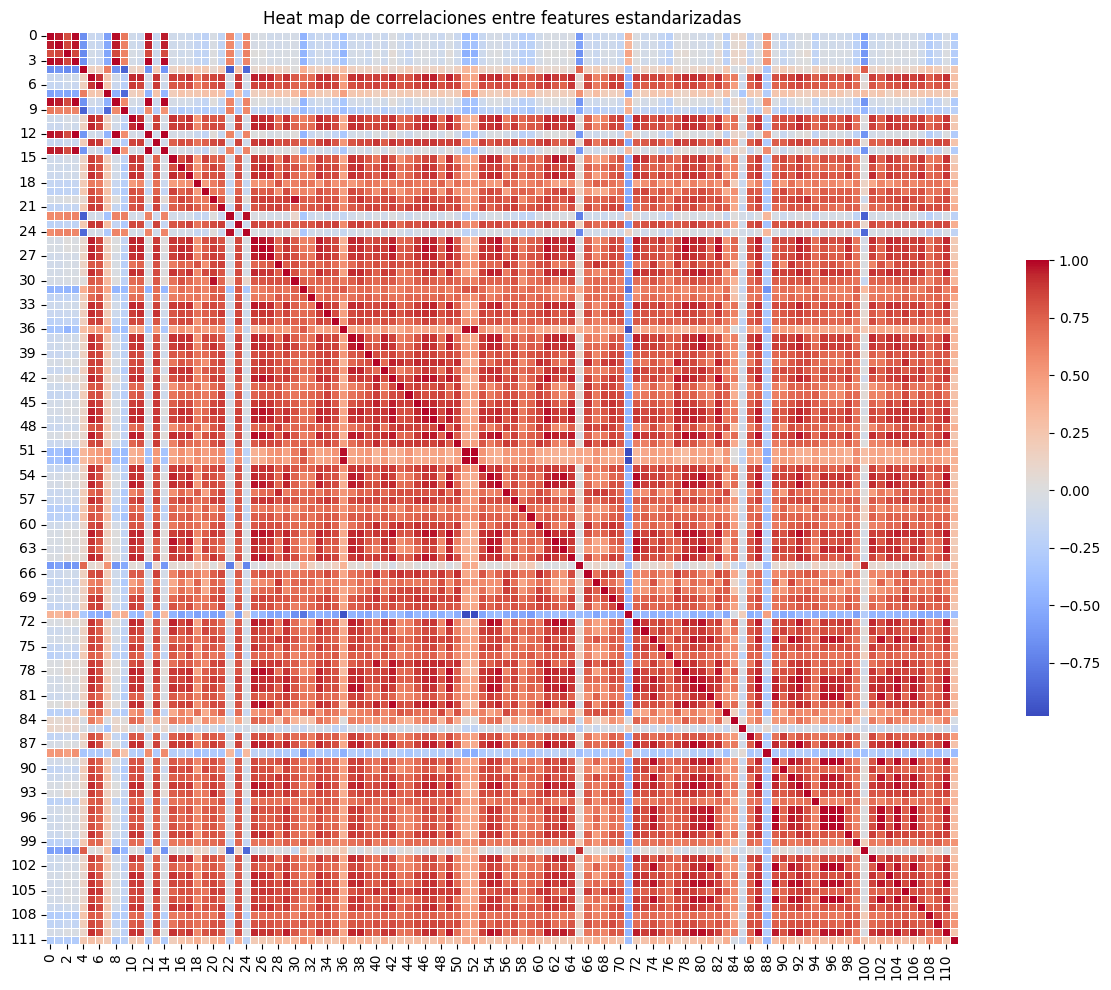

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación
corr_matrix = X_scaled_df.corr()

# Graficar heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5}
)
plt.title("Heat map de correlaciones entre features estandarizadas")
plt.tight_layout()
plt.show()


In [184]:
def eliminar_correlacionadas(df, threshold=0.9): #de 0.9 a mas
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    columnas_a_eliminar = [col for col in upper.columns if any(upper[col] > threshold)]
    print(f"Se eliminarán {len(columnas_a_eliminar)} columnas por alta correlacion")
    return df.drop(columns=columnas_a_eliminar)

# Usar el DataFrame con columnas
X_no_corr = eliminar_correlacionadas(X_scaled_df)



Se eliminarán 72 columnas por alta correlacion


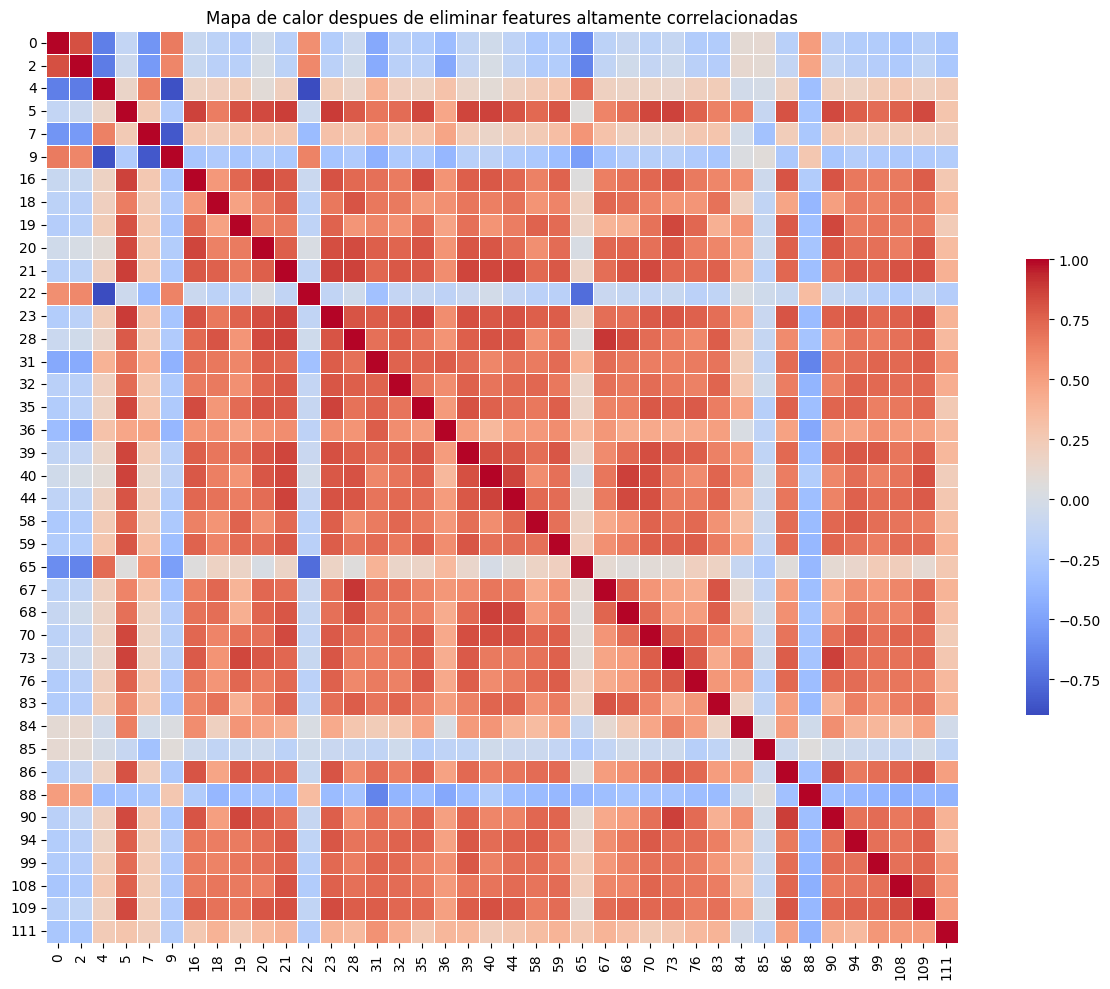

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la nueva matriz de correlación
corr_matrix_post = X_no_corr.corr()

# Graficar heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix_post,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5}
)
plt.title("Mapa de calor despues de eliminar features altamente correlacionadas")
plt.tight_layout()
plt.show()


In [186]:
print("Cantidad de features finales sin alta correlación:", X_no_corr.shape[1])

Cantidad de features finales sin alta correlación: 40


In [187]:
X_no_corr.to_csv('features_40.csv', index=False)

In [ ]:
# Exploracion de la data 
#Se deben hacer varios graficos para visualizar la data y tomar el mejor modelo
#Ver cuales tienen mas relacion con y, no calcular todo o ver todos los features. 
# #usar pearson o Mutual information(mas recomendada, porque los valores que estan en
#  y son categoricos y los de x son numericos - funciona god por ese motivo) mejor pearson no, pearson es mejor para regresion

In [ ]:
## Entrenamiento 

#parametros

# GridSearch CV
#Usa cross validation
#Guardar en un diccionario de hiperparametros 

#Sustentar con metricas

In [ ]:
# Modelos a comparar
modelos = {
    'decision_tree': DecisionTreeClassifier(random_state=42),
    #'knn' #completar
}





# Hiperparámetros
hiperparametros = {
    'decision_tree': {
        'splitter': ['best', 'random'],
        'max_depth': [5, 10, 15]
    },
    'regresion_logistica': {
        'penalty': ['l1', 'l2'], 
        'C': [0.01, 0.1, 1],
        'max_iter': [100, 500, 1000]
    }
    
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [58]:

#hiperparametros = {
 #   'decision_tree': {
  #      'splitter': ['best', 'random'], # estrategia para dividir los nodos
  #  'regresion_logistica': {
     #   'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
   #     'max_iter': [100, 500, 1000]
    #}
                                            
    #}
#}


# Modelado

In [59]:
modelos = {
    "decision_tree" : DecisionTreeClassifier(random_state=42)
}

# Entrenar

In [ ]:
# hacemos un codigo donde cada uno de los modelos, pruebe con cada uno de tus mejores hiperparametros y te bote el mejor resultado

# El mejor modelo con el resultado, haz una condicional simple donde pruebe con cada uno, 
# veas el mejor modelo si excede las metricas del anterior te quedas con uno u otro